In [1]:
# Copyright (c) 2021-2060 Curtis G. Northcutt
# This file is part of cgnorthcutt/label-errors.
#
# label-errors is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# cgnorthcutt/label-errors is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License

# This agreement applies to this version and all previous versions of
# cgnorthcutt/label-errors.

"""
This tutorial provides reproducible code to find the label errors for 8 of
the 10 datasets, using the pyx (predicted probs), pred (predicted labels),
and test label files, available in cgnorthcutt/label-errors.

The quickdraw dataset is excluded because the pyx file is 33GB and might
cause trouble on some machines. We also exclude caltech-256 because we used a
low capacity model and its not reflective of recent performance.

This tutorial reproduces how we find the label errors on https://labelerrors.com
(prior to human validation on mTurk).
"""

import cleanlab
import numpy as np
import json
from util import ALL_CLASSES
# To view the text data from labelerrors.com, we need:
from urllib.request import urlopen
# To view the image data from labelerrors.com, we need:
from skimage import io
from matplotlib import pyplot as plt

# Remove axes since we're plotting images, not graphs
rc = {"axes.spines.left" : False,
      "axes.spines.right" : False,
      "axes.spines.bottom" : False,
      "axes.spines.top" : False,
      "xtick.bottom" : False,
      "xtick.labelbottom" : False,
      "ytick.labelleft" : False,
      "ytick.left" : False}
plt.rcParams.update(rc)

In [2]:
datasets = [
    ('imagenet_val_set', 'image'),
    ('mnist_test_set', 'image'),
    ('cifar10_test_set', 'image'),
    ('cifar100_test_set', 'image'),
    ('imdb_test_set', 'text'),
    ('20news_test_set', 'text'),
    ('amazon', 'text'),
    ('audioset_eval_set', 'audio'),
]


In [3]:
# Load the filename mappings for various datasets
with open("../resources/audioset_eval_set_index_to_youtube_id.json", 'r') as rf:
    AUDIOSET_INDEX_TO_YOUTUBE = json.load(rf)
with open("../resources/imdb_test_set_index_to_filename.json", 'r') as rf:
    IMDB_INDEX_TO_FILENAME = json.load(rf)
with open("../resources/imagenet_val_set_index_to_filepath.json", 'r') as rf:
    IMAGENET_INDEX_TO_FILEPATH = json.load(rf)

# Find label errors in each dataset

Dataset: Imagenet_val_set
Finding label errors using cleanlab for 50,000 examples and 1000 classes...


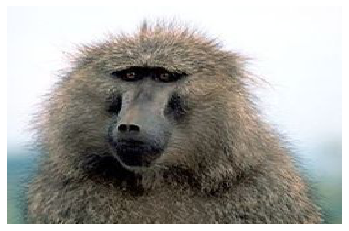

 * Imagenet_val_set Given Label: siamang
 * We Guess (argmax prediction): baboon
 * Label Error Found: https://labelerrors.com/static/imagenet/val/n02483708/ILSVRC2012_val_00047520.JPEG

Dataset: Mnist_test_set
Finding label errors using cleanlab for 10,000 examples and 10 classes...


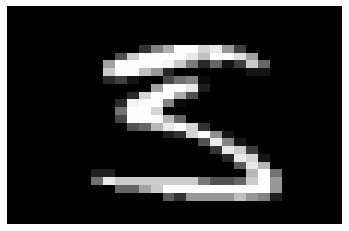

 * Mnist_test_set Given Label: 5
 * We Guess (argmax prediction): 3
 * Label Error Found: https://labelerrors.com/static/mnist/2597.png

Dataset: Cifar10_test_set
Finding label errors using cleanlab for 10,000 examples and 10 classes...


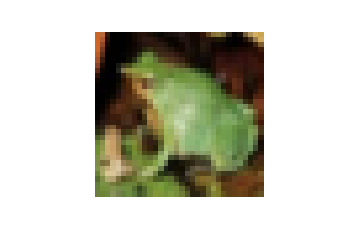

 * Cifar10_test_set Given Label: cat
 * We Guess (argmax prediction): frog
 * Label Error Found: https://labelerrors.com/static/cifar10/2405.png

Dataset: Cifar100_test_set
Finding label errors using cleanlab for 10,000 examples and 100 classes...


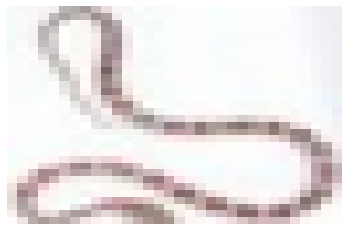

 * Cifar100_test_set Given Label: snake
 * We Guess (argmax prediction): worm
 * Label Error Found: https://labelerrors.com/static/cifar100/5369.png

Dataset: Imdb_test_set
Finding label errors using cleanlab for 25,000 examples and 2 classes...

Imdb_test_set Text Example (ID: 5289):
Masterpiece. Carrot Top blows the screen away. Never has one movie captured the essence of the human spirit quite like "Chairman of the Board." 10/10... don't miss this instant classic.

 * Imdb_test_set Given Label: Negative
 * We Guess (argmax prediction): Positive
 * Label Error Found: https://labelerrors.com/static/imdb/test/neg/6637_1.txt

Dataset: 20news_test_set
Finding label errors using cleanlab for 7,532 examples and 20 classes...

20news_test_set Text Example (ID: 6053):
From: rwf2@ns1.cc.lehigh.edu (ROBERT WILLIAM FUSI)
Subject: FOR SALE: '91 Toyota Camry $9500
Organization: Lehigh University
Lines: 20

1991 Toyota Camry for sale:
    Deluxe package
    5 speed
    grey
    power windows
    p

In [4]:
for (dataset, modality) in datasets:
    title = 'Dataset: ' + dataset.capitalize()
    print('='*len(title), title, '='*len(title), sep='\n')
    
    # Get the cross-validated predicted probabilities on the test set.
    if dataset == 'amazon' or dataset == 'imagenet_val_set':
        n_parts = 3 if dataset == 'amazon' else 4
        pyx_fn = '../cross_validated_predicted_probabilities/' \
             '{}_pyx.part{}_of_{}.npy'
        parts = [np.load(pyx_fn.format(dataset, i + 1, n_parts)) for i in range(n_parts)]
        pyx = np.vstack(parts)
    else:
        pyx = np.load('../cross_validated_predicted_probabilities/' \
            '{}_pyx.npy'.format(dataset), allow_pickle=True)
    # Get the cross-validated predictions (argmax of pyx) on the test set.
    pred = np.load('../cross_validated_predicted_labels/'
        '{}_pyx_argmax_predicted_labels.npy'.format(dataset), allow_pickle=True)
    # Get the test set labels
    test_labels = np.load('../original_test_labels/'
        '{}_original_labels.npy'.format(dataset), allow_pickle=True)
    
    # Find label error indices using cleanlab in one line of code.
    print('Finding label errors using cleanlab for {:,} examples and {} classes...'.format(*pyx.shape))
    label_error_indices = cleanlab.pruning.get_noise_indices(
        s=test_labels, # np.asarray([z[0] for z in y_test]),
        psx=pyx,
        prune_method='both',
        multi_label=True if dataset == 'audioset_eval_set' else False,
        sorted_index_method='normalized_margin',
    )
    
    # Grab a label error found with cleanlab
    err_id = label_error_indices[0]
    
    # Custom code to visualize each label error from each dataset
    dname = dataset.split('_')[0]  # Get dataset name
    url_base = "https://labelerrors.com/static/{}/{}".format(dname, err_id)
    if modality == 'image':
        if dataset == 'imagenet_val_set':
            image_path = IMAGENET_INDEX_TO_FILEPATH[err_id]
            url = url_base.replace(str(err_id), image_path)
        else:
            url = url_base + ".png"
        image = io.imread(url)  # read image data from a url
        plt.imshow(image, interpolation='nearest', aspect='auto', cmap='gray')
        plt.show()
    elif modality == 'text':
        if dataset == 'amazon':
            # There are 400,000+ amazon reviews errors -- we only check a small
            # fraction on labelerrors.com, so choose one that's on the website.
            err_id = 8864504
            assert err_id in label_error_indices  # Did we find this error?
            url = "https://labelerrors.com/static/{}/{}.txt".format(dname, err_id)
        elif dataset == 'imdb_test_set':
            imdb_fn = IMDB_INDEX_TO_FILENAME[err_id]  
            url = "https://labelerrors.com/static/{}/test/{}".format(dname, imdb_fn)
        else:
            url = url_base + ".txt"
        text = urlopen(url).read().decode("utf-8")  # read raw text from a url
        print('\n{} Text Example (ID: {}):\n{}\n'.format(
            dataset.capitalize(), err_id, text))
    elif modality == 'audio':  # dataset == 'audioset_eval_set'
        # Because AudioSet is multi-label, we only look at examples where the 
        # predictions have no overlap with the labels to avoid overcounting.
        label_error_indices = [z for z in label_error_indices \
                if set(pred[z]).intersection(test_labels[z]) == set()]
        err_id = label_error_indices[1]
        youtube_id = AUDIOSET_INDEX_TO_YOUTUBE[err_id]
        url = youtube_id.replace('http', 'https')
    # Map label indices to class names
    if dataset == 'audioset_eval_set':  # multi-label    
        given_label = [ALL_CLASSES[dataset][z] for z in test_labels[err_id]]
        pred_label = [ALL_CLASSES[dataset][z] for z in pred[err_id]]
    else:  # single-label
        given_label = ALL_CLASSES[dataset][test_labels[err_id]]
        pred_label = ALL_CLASSES[dataset][pred[err_id]]
    print(' * {} Given Label:'.format(dataset.capitalize()), given_label)
    print(' * We Guess (argmax prediction):', pred_label)
    print(' * Label Error Found: {}\n'.format(url))